In [1]:
import os
import librosa
import time
import glob
import csv
import cv2
import librosa.display
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import shutil


from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.layers.normalization import BatchNormalization
from numpy import array, asarray, ndarray, swapaxes

Using TensorFlow backend.


In [2]:
df_tracks = pd.read_csv('fma_metadata/tracks.csv')

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (2,6,7,24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Organiza dados

    Organiza as músicas em pastas por gêneros

In [9]:
root = '../fma_small/'
dest = '../musics_by_genre/'


for folder in os.listdir(root):
    folderpath = '{}/{}'.format(root, folder)
        
    for filename in os.listdir(folderpath):
        fullpath = '{}/{}'.format(folderpath, filename)
        
        current_track_id = filename.split('.')[0]
        current_track_id = int(current_track_id)
        
        # Searchs for current track in df
        genre = df_tracks[df_tracks.track_id == current_track_id]   
        # Gets genre from pandas Series
        genre = genre.genre_top.tolist()[0]
        
        savefolder = '{}/{}'.format(dest, genre)
        print(savefolder)
        if not os.path.exists(savefolder):
            os.makedirs(savefolder)
    
        shutil.move(fullpath, savefolder)

../musics_by_genre//Electronic
../musics_by_genre//Instrumental
../musics_by_genre//International
../musics_by_genre//Rock
../musics_by_genre//Electronic
../musics_by_genre//Instrumental
../musics_by_genre//Instrumental
../musics_by_genre//Folk
../musics_by_genre//Rock
../musics_by_genre//Instrumental
../musics_by_genre//Rock
../musics_by_genre//Electronic
../musics_by_genre//Instrumental
../musics_by_genre//Instrumental
../musics_by_genre//Hip-Hop
../musics_by_genre//Rock
../musics_by_genre//Rock
../musics_by_genre//Pop
../musics_by_genre//Instrumental
../musics_by_genre//Rock
../musics_by_genre//Rock
../musics_by_genre//Rock
../musics_by_genre//International
../musics_by_genre//Instrumental
../musics_by_genre//Hip-Hop
../musics_by_genre//Rock
../musics_by_genre//Experimental
../musics_by_genre//Hip-Hop
../musics_by_genre//Rock
../musics_by_genre//International
../musics_by_genre//Rock
../musics_by_genre//Instrumental
../musics_by_genre//Rock
../musics_by_genre//Hip-Hop
../musics_by_g

../musics_by_genre//Folk
../musics_by_genre//Rock
../musics_by_genre//International
../musics_by_genre//International
../musics_by_genre//International
../musics_by_genre//Pop
../musics_by_genre//Instrumental
../musics_by_genre//Rock
../musics_by_genre//Instrumental
../musics_by_genre//International
../musics_by_genre//Hip-Hop
../musics_by_genre//International
../musics_by_genre//Pop
../musics_by_genre//Pop
../musics_by_genre//Folk
../musics_by_genre//Instrumental
../musics_by_genre//International
../musics_by_genre//Electronic
../musics_by_genre//Pop
../musics_by_genre//Instrumental
../musics_by_genre//Folk
../musics_by_genre//Pop
../musics_by_genre//Hip-Hop
../musics_by_genre//Electronic
../musics_by_genre//Instrumental
../musics_by_genre//International
../musics_by_genre//Instrumental
../musics_by_genre//International
../musics_by_genre//International
../musics_by_genre//Instrumental
../musics_by_genre//Experimental
../musics_by_genre//Rock
../musics_by_genre//International
../music

../musics_by_genre//Hip-Hop
../musics_by_genre//Pop
../musics_by_genre//Folk
../musics_by_genre//Pop
../musics_by_genre//Folk
../musics_by_genre//Pop
../musics_by_genre//Hip-Hop
../musics_by_genre//Pop
../musics_by_genre//Rock
../musics_by_genre//Hip-Hop
../musics_by_genre//Folk
../musics_by_genre//Pop
../musics_by_genre//Rock
../musics_by_genre//Folk
../musics_by_genre//Rock
../musics_by_genre//Pop
../musics_by_genre//Hip-Hop
../musics_by_genre//Rock
../musics_by_genre//Pop
../musics_by_genre//Pop
../musics_by_genre//Hip-Hop
../musics_by_genre//Hip-Hop
../musics_by_genre//Hip-Hop
../musics_by_genre//International
../musics_by_genre//Rock
../musics_by_genre//Electronic
../musics_by_genre//Pop
../musics_by_genre//Rock
../musics_by_genre//Hip-Hop
../musics_by_genre//Pop
../musics_by_genre//Instrumental
../musics_by_genre//Hip-Hop
../musics_by_genre//Instrumental
../musics_by_genre//Pop
../musics_by_genre//Pop
../musics_by_genre//Hip-Hop
../musics_by_genre//Instrumental
../musics_by_genre

../musics_by_genre//Rock
../musics_by_genre//Rock
../musics_by_genre//Hip-Hop
../musics_by_genre//Experimental
../musics_by_genre//Folk
../musics_by_genre//Rock
../musics_by_genre//Electronic
../musics_by_genre//Rock
../musics_by_genre//Pop
../musics_by_genre//Rock
../musics_by_genre//Instrumental
../musics_by_genre//Pop
../musics_by_genre//Instrumental
../musics_by_genre//Pop
../musics_by_genre//Instrumental
../musics_by_genre//Folk
../musics_by_genre//Instrumental
../musics_by_genre//Hip-Hop
../musics_by_genre//Rock
../musics_by_genre//Instrumental
../musics_by_genre//Instrumental
../musics_by_genre//Folk
../musics_by_genre//Rock
../musics_by_genre//Rock
../musics_by_genre//Hip-Hop
../musics_by_genre//Folk
../musics_by_genre//Pop
../musics_by_genre//Pop
../musics_by_genre//Hip-Hop
../musics_by_genre//Pop
../musics_by_genre//Hip-Hop
../musics_by_genre//Pop
../musics_by_genre//Pop
../musics_by_genre//Rock
../musics_by_genre//Folk
../musics_by_genre//Rock
../musics_by_genre//Pop
../musi

NotADirectoryError: [Errno 20] Not a directory: '../fma_small//README.txt'

### Transforms images from a directory in spectrograms

In [2]:
def audio_to_image(filepath, savepath='./images/'):
    
    filepath = os.path.abspath(filepath)
    savepath = os.path.abspath(savepath)
    mpl.rcParams['savefig.pad_inches'] = 0
    # Reads every audio file from filepath, returns amplitude in time(y) and sample rate(sr)
    for folder in os.listdir(filepath):
        folderpath = '{}/{}'.format(filepath, folder)
        
        for filename in os.listdir(folderpath):
            fullpath = '{}/{}'.format(folderpath, filename)
            print(fullpath)
            audio_wave, sample_rate = librosa.load(fullpath)

            # Applies Fourier transform in audio's amplitude
            fourier = librosa.stft(audio_wave)

            # Converts amplitude to DBs
            """
            ref:scalar or callable
                If scalar, the amplitude abs(S) is scaled relative to ref: 20 * log10(S / ref). 
                Zeros in the output correspond to positions where S == ref.

                If callable, the reference value is computed as ref(S).
            """
            D = librosa.amplitude_to_db(np.abs(fourier), ref=np.max)
            
           
            librosa.display.specshow(D, x_axis='time', y_axis='log')
            plt.axis('off')
            #plt.axis('off')
            
            savefolder = '{}/{}'.format(savepath, folder)
            
            if not os.path.exists(savefolder):
                os.makedirs(savefolder)
            
            plt.savefig(savefolder + '/' + filename.split('.')[0] + '-spectogram.png', bbox_inches='tight',  pad_inches=0)

In [ ]:
audio_to_image('./teste/')

### Handles Genres DataSet import and conversion

In [14]:
### Loads audio Data CSV
df_tracks = pd.read_csv('fma_metadata/tracks.csv')
df_tracks.dropna(subset = ['genre_top'], inplace = True)

genres_id = {"Hip-Hop": 1,
             "Pop": 2,
             "Rock": 3,
             "Experimental": 4,
             "Spoken": 5,
             "Folk": 6,
             "Jazz": 7,
             "Electronic": 8,
             "International": 9,
             "Soul-RnB": 10,
             "Blues": 11,
             "Country": 12,
             "Classical": 13,
             "Old-Time / Historic": 14,
             "Instrumental": 15,
             "Easy Listening": 16,
             "1": 3}

df_tracks = df_tracks.replace({"genre_top": genres_id})
df_tracks.head()

,track_id,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,...,publisher,tags,title,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27
0,2,256000,0,NaN,2008-11-26 01:48:12,2008-11-26 00:00:00,168,2,1,[21],...,NaN,[],Food,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,256000,0,NaN,2008-11-26 01:48:14,2008-11-26 00:00:00,237,1,1,[21],...,NaN,[],Electric Ave,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,256000,0,NaN,2008-11-26 01:48:20,2008-11-26 00:00:00,206,6,1,[21],...,NaN,[],This World,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26 00:00:00,161,178,2,[10],...,NaN,[],Freeway,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,134,256000,0,NaN,2008-11-26 01:43:19,2008-11-26 00:00:00,207,3,1,[21],...,NaN,[],Street Music,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
df_tracks.head()

,track_id,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,...,publisher,tags,title,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27
0,2,256000,0,NaN,2008-11-26 01:48:12,2008-11-26 00:00:00,168,2,1,[21],...,NaN,[],Food,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,256000,0,NaN,2008-11-26 01:48:14,2008-11-26 00:00:00,237,1,1,[21],...,NaN,[],Electric Ave,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,256000,0,NaN,2008-11-26 01:48:20,2008-11-26 00:00:00,206,6,1,[21],...,NaN,[],This World,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26 00:00:00,161,178,2,[10],...,NaN,[],Freeway,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,134,256000,0,NaN,2008-11-26 01:43:19,2008-11-26 00:00:00,207,3,1,[21],...,NaN,[],Street Music,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Defines model's training options and params

In [27]:
# Number of samples propagated through the network
batch_size = 10

# Number of epochs  to avoid overfitting
epochs = 5

# Default Training size
training_size = 0.7

# Image's dimensions
img_rows, img_cols = 248, 387 

# Training data size (Where 95 = n of images)
length = int((95+150)*training_size)

### Create train and tests sets from image's directory

In [33]:
def create_set(filepath):
    
    # Initializes train sets
    x_test = []
    x_train = []

    y_test = []
    y_train = []
    
    filepath = os.path.abspath(filepath)
    
    i = 0
    for folder in os.listdir(filepath):
        folderpath = '{}/{}'.format(filepath, folder)
        
        for filename in os.listdir(folderpath):
            fullpath = '{}/{}'.format(folderpath, filename)
            
            current_track_id = filename.split('-')[0]
            current_track_id = int(current_track_id)
            
            # Searchs for current track in df
            genre = df_tracks[df_tracks.track_id == current_track_id]
            
            # Gets genre from pandas Series
            genre = genre.genre_top.to_list()[0]
            
            print(i, fullpath, current_track_id, genre)

            img = cv2.imread(fullpath)
            img = cv2.resize(img, (img_cols, img_rows))

            if(i < length):
                x_train.append(img)
                y_train.append(genre)
            else:
                x_test.append(img)
                y_test.append(genre)
        
            i = i + 1

    return x_train, y_train, x_test, y_test   

In [34]:
x_train, y_train, x_test, y_test = create_set('images')

(0, '/audios/images/014/014603-spectogram.png', 14603, 9)
(1, '/audios/images/014/014735-spectogram.png', 14735, 3)
(2, '/audios/images/014/014734-spectogram.png', 14734, 3)
(3, '/audios/images/014/014744-spectogram.png', 14744, 3)
(4, '/audios/images/014/014684-spectogram.png', 14684, 6)
(5, '/audios/images/014/014586-spectogram.png', 14586, 15)
(6, '/audios/images/014/014344-spectogram.png', 14344, 8)
(7, '/audios/images/014/014584-spectogram.png', 14584, 15)
(8, '/audios/images/014/014577-spectogram.png', 14577, 15)
(9, '/audios/images/014/014572-spectogram.png', 14572, 15)
(10, '/audios/images/014/014208-spectogram.png', 14208, 8)
(11, '/audios/images/014/014542-spectogram.png', 14542, 1)
(12, '/audios/images/014/014063-spectogram.png', 14063, 8)
(13, '/audios/images/014/014579-spectogram.png', 14579, 15)
(14, '/audios/images/014/014739-spectogram.png', 14739, 3)
(15, '/audios/images/014/014315-spectogram.png', 14315, 9)
(16, '/audios/images/014/014745-spectogram.png', 14745, 3)
(1

(139, '/audios/images/001/001735-spectogram.png', 1735, 4)
(140, '/audios/images/001/001069-spectogram.png', 1069, 4)
(141, '/audios/images/001/001259-spectogram.png', 1259, 4)
(142, '/audios/images/001/001703-spectogram.png', 1703, 6)
(143, '/audios/images/001/001196-spectogram.png', 1196, 6)
(144, '/audios/images/001/001685-spectogram.png', 1685, 9)
(145, '/audios/images/001/001073-spectogram.png', 1073, 4)
(146, '/audios/images/001/001702-spectogram.png', 1702, 6)
(147, '/audios/images/001/001082-spectogram.png', 1082, 9)
(148, '/audios/images/001/001066-spectogram.png', 1066, 4)
(149, '/audios/images/001/001482-spectogram.png', 1482, 8)
(150, '/audios/images/001/001102-spectogram.png', 1102, 3)
(151, '/audios/images/001/001681-spectogram.png', 1681, 9)
(152, '/audios/images/001/001891-spectogram.png', 1891, 3)
(153, '/audios/images/001/001075-spectogram.png', 1075, 4)
(154, '/audios/images/001/001682-spectogram.png', 1682, 9)
(155, '/audios/images/001/001925-spectogram.png', 1925, 

In [30]:
pd.DataFrame(y_train, columns=['genre']).genre.value_counts()

8     27
1     25
3     24
4     22
9     21
2     19
15    18
6     14
2      1
Name: genre, dtype: int64

In [37]:
pd.DataFrame(y_test, columns=['genre']).genre.value_counts()

6      15
9      12
4      10
2      10
3       8
15      5
1       5
8       3
261     1
Name: genre, dtype: int64

In [14]:
df_tracks[df_tracks.genre_top == 4].head(50)

,track_id,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,...,publisher,tags,title,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27
12,137,256000,0,NaN,2008-11-26 01:43:42,1978-04-27 00:00:00,1233,2,4,"[1, 32]",...,NaN,['lafms'],Side A,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,138,256000,0,NaN,2008-11-26 01:43:56,1978-04-27 00:00:00,1231,2,4,"[1, 32]",...,NaN,['lafms'],Side B,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,148,256000,0,NaN,2008-11-26 01:44:28,2002-08-01 00:00:00,138,1,4,[1],...,NaN,[],Blackout 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,149,287639,0,NaN,2008-11-26 01:44:34,2006-01-01 00:00:00,988,1,4,[1],...,NaN,[],Outside the window bees buzzed...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,150,282817,0,NaN,2008-11-26 01:44:45,2006-01-01 00:00:00,1182,0,4,[1],...,NaN,[],... listening to the sunshine burn the grass,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,156,192000,0,NaN,2008-11-26 01:45:18,2004-08-20 00:00:00,122,2,4,[30],...,NaN,[],Track 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,157,192000,0,NaN,2008-11-26 01:45:21,2004-08-20 00:00:00,212,1,4,[30],...,NaN,[],Track 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,158,192000,0,NaN,2008-11-26 01:45:25,2004-08-20 00:00:00,473,1,4,[30],...,NaN,[],Track 03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,159,192000,0,NaN,2008-11-26 01:45:28,2004-08-20 00:00:00,221,1,4,[30],...,NaN,[],Track 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,160,192000,0,NaN,2008-11-26 01:45:31,2004-08-20 00:00:00,70,0,4,[30],...,NaN,[],Track 05,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# Converting the data from lists to numpy arrays
x_train = asarray(x_train)
x_test = asarray(x_test)
y_train = asarray(y_train)
y_test = asarray(y_test)

# Scaling down the RGB data
x_train = x_train / 255
x_test = x_test / 255

# Printing stats about the features
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

('x_train shape:', (171, 248, 387, 3))
('x_test shape:', (69, 248, 387, 3))
(171, 'train samples')
(69, 'test samples')


In [42]:
y_train

array(['9', '3', '3', '3', '6', '15', '8', '15', '15', '15', '8', '1',
       '8', '15', '3', '9', '3', '15', '15', '15', '3', '3', '15', '3',
       '9', '9', '15', '15', '1', '1', '1', '15', '15', '9', '1', '3',
       '3', '4', '9', '9', '1', '6', '9', '15', '15', '9', '3', '6', '8',
       '3', '6', '3', '15', '3', '2', '9', '3', '15', '8', '8', '8', '3',
       '2', '2', '1', '2', '4', '1', '6', '2', '2', '8', '8', '8', '4',
       '9', '8', '9', '1', '1', '1', '8', '9', '2', '2', '8', '2', '1',
       '8', '1', '8', '6', '9', '2', '3', '8', '8', '8', '9', '2', '1',
       '1', '8', '2', '1', '1', '1', '8', '2', '8', '1', '4', '1', '1',
       '8', '2', '2', '1', '4', '4', '4', '1', '1', '4', '4', '4', '8',
       '1', '15', '4', '8', '8', '2', '4', '8', '2', '3', '2', '4', '4',
       '4', '4', '6', '6', '9', '4', '6', '9', '4', '8', '3', '9', '3',
       '4', '9', '6', '3', '6', '6', '6', '2', '2', '9', '9', '6', '3',
       '3', '4', '4', '3', '4'], dtype='|S21')

### Model's definitions and Convolutions

In [36]:
model = Sequential()

# kernel_size najela de convolução
# Ir crescendo o numero de canais
model.add(Conv2D(128,data_format = 'channels_last', kernel_size=(3, 3),
                 input_shape=(img_rows, img_cols,3)))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (2,2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (2,2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (2,2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (2,2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (2,2)))
model.add(Activation('relu'))
model.add(Dropout(0.2))

# Dense layers
model.add(Flatten())

model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dropout(0.15))

model.add(Dense(8))
model.add(Activation('relu'))
model.add(Dropout(0.15))

model.add(Dense(4))
model.add(Activation('relu'))
model.add(Dropout(0.15))

# Output
model.add(Dense(1))

# Printing model summary
print(model.summary())

# Compiling the model
model.compile(optimizer='RMSprop', loss='mse', metrics=['mae'])

# Training the model
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 246, 385, 128)     3584      
_________________________________________________________________
activation_21 (Activation)   (None, 246, 385, 128)     0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 246, 385, 128)     0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 244, 383, 64)      73792     
_________________________________________________________________
activation_22 (Activation)   (None, 244, 383, 64)      0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 81, 127, 64)       0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 81, 127, 64)       0         
__________

### Evaluate the model

In [38]:
score = model.evaluate(x_test, y_test, batch_size = batch_size, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

('Test loss:', 1012.4447367986044)
('Test accuracy:', 8.269591932711394)


### Example image

[1.124609]


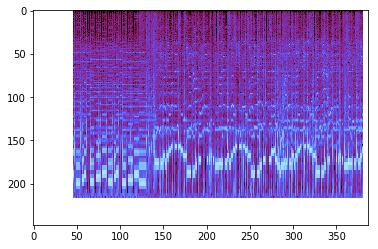

In [39]:
test_image = cv2.imread("021085-spectogram.png")
unique_image = []
unique_image.append(test_image)
unique_image = asarray(unique_image)
unique_image = unique_image / 255

prediction = model.predict(unique_image, batch_size = batch_size, verbose = 0)

plt.imshow(test_image)
print(prediction[0])
